In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


import sys
import os

import sys
import os
sys.path.append(os.path.abspath("../../.."))

from Preprocessing.imputation import get_imputation_maps, apply_imputation, ContextImputer
from Preprocessing.brand_equals_model import BrandModelFixer

from Preprocessing.split_new_drop_models import split_data
from utils.scatter_plot import scatter_prediction
from utils.eval_call import evaluate_model
import seaborn as sns 
from sklearn.metrics import mean_absolute_error

In [4]:
X_train, X_test, y_train, y_test, categorical_features , numeric_features = split_data('../../../data.csv')

# Preprocessing-Pipelines erstellen
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

transformed_model = TransformedTargetRegressor(
    regressor=LinearRegression(),
    func=np.log1p,
    inverse_func=np.expm1
)


linear_regression_pipeline = Pipeline(steps=[
    ('imp_fc', ContextImputer('fuel_consumption_l_100km')),
    ('imp_ps', ContextImputer('power_ps')),
    ('imp_er', ContextImputer('electric_range')),
    ('preprocessor', preprocessor),
    ('model', transformed_model)
])

# Modell trainieren
linear_regression_pipeline.fit(X_train, y_train)

# Vorhersagen treffen
y_pred_lr = linear_regression_pipeline.predict(X_test)



evaluate_model(y_test, y_pred_lr, "Linear Regression")

# Prüfe, ob fuel_type in X_test enthalten ist
if 'fuel_type' in X_test.columns:
    results_df = pd.DataFrame({
        'fuel_type': X_test['fuel_type'].values,
        'y_true': y_test.values,
        'y_pred': y_pred_lr
    })

    # Nach evaluate_model(...)





Linear Regression Performance Metrics:
MAE: 3821.30
MSE: 247578681.25
RMSE: 15734.63
R²: 0.80
------------------------------


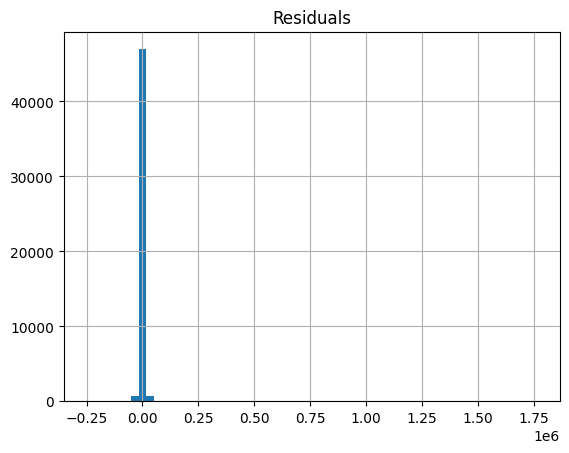

fuel
CNG              2424.182329
Ethanol          2596.740009
LPG              2954.729817
Diesel           3417.475862
Petrol           3900.664809
Other            4231.085259
Electric         4894.906861
Hybrid           5274.998204
Unknown          5758.528636
Diesel Hybrid    6128.549226
Hydrogen         7038.349845
dtype: float64


/var/folders/y9/d279tz1j1k957cycwlj25_6h0000gn/T/ipykernel_63657/775864535.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: mean_absolute_error(d.y_true, d.y_pred))


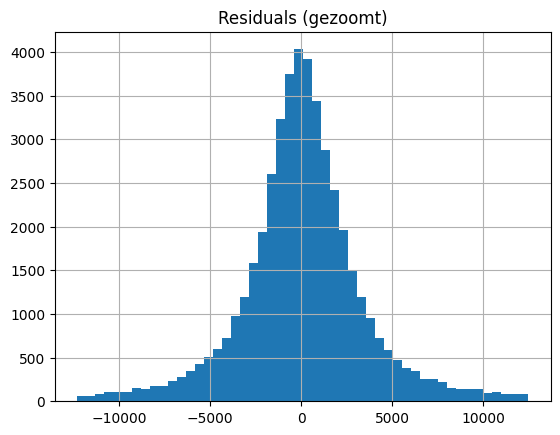

Ausreißer-Anteil: 4.857313827043312 %


In [5]:
results = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_lr,
    'fuel'  : X_test['fuel_type'].values,
    'brand' : X_test['brand'].values,
    'model'  : X_test['model'].values,
})

# 1) Residual Histogram
results['res'] = results.y_true - results.y_pred
results.res.hist(bins=60); plt.title('Residuals'); plt.show()

# 2) MAE nach fuel_type
print(results.groupby('fuel')
    .apply(lambda d: mean_absolute_error(d.y_true, d.y_pred))
    .sort_values())
    # Residuen-Array
res = results.res

# nur Residuen innerhalb ±3*IQR anzeigen
q1, q3 = np.percentile(res, [25, 75])
iqr = q3 - q1
mask = (res > q1 - 3*iqr) & (res < q3 + 3*iqr)

res[mask].hist(bins=50)
plt.title("Residuals (gezoomt)")
plt.show()
print("Ausreißer-Anteil:", (~mask).mean()*100, "%")


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt 

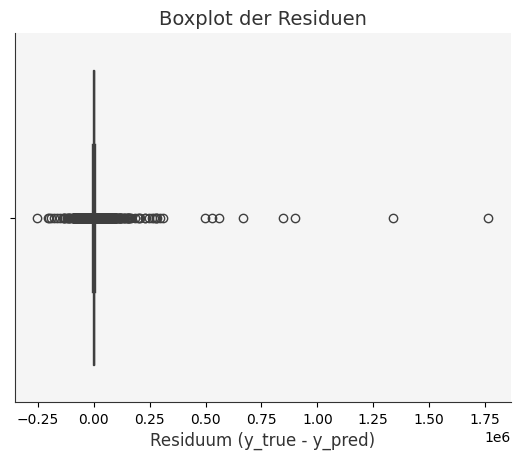

In [7]:
sns.boxplot(data=results, x = 'res')
plt.title("Boxplot der Residuen")
plt.xlabel("Residuum (y_true - y_pred)")
sns.despine()
plt.gca().patch.set_facecolor('#f5f5f5')
plt.gca().spines['bottom'].set_color('#333')
plt.gca().spines['left'].set_color('#333')
plt.xlabel("Residuum (y_true - y_pred)", fontsize=12, color='#333')
plt.title("Boxplot der Residuen", fontsize=14, color='#333')
plt.show()

In [8]:

pd.set_option('display.float_format', lambda x: f'{x:,.0f}')

In [9]:
results.sort_values(by='res', ascending= False)

,y_true,y_pred,fuel,brand,model,res
40898,1990000,"225,681",Hybrid,porsche,Porsche 918,"1,764,319"
36213,1580000,"243,320",Petrol,porsche,Porsche Carrera GT,"1,336,680"
24009,999999,"100,387",Petrol,mercedes-benz,Mercedes-Benz CLK 55 AMG,"899,612"
10145,1150000,"303,387",Petrol,ferrari,Ferrari 599,"846,613"
20028,779000,"112,833",Petrol,ferrari,Ferrari SF90 Spider,"666,167"
...,...,...,...,...,...,...
39278,229900,"405,787",Petrol,lamborghini,Lamborghini Murciélago,"-175,887"
18709,349000,"538,638",Petrol,lamborghini,Lamborghini Aventador,"-189,638"
11044,297000,"496,278",Petrol,lamborghini,Lamborghini Murciélago,"-199,278"
26695,76041,"281,546",Petrol,porsche,Porsche 911,"-205,505"


In [10]:
X_test.iloc[742]

brand                            volkswagen
model                       Volkswagen Golf
color                                  blue
year                                   2009
power_ps                                122
transmission_type                    Manual
fuel_type                            Petrol
fuel_consumption_l_100km                  6
mileage_in_km                       199,500
electric_range                            0
registration_month                        4
Name: 742, dtype: object

In [11]:
X_test.iloc[9473]

brand                             ford
model                       Ford Focus
color                            black
year                              2013
power_ps                           140
transmission_type            Automatic
fuel_type                       Diesel
fuel_consumption_l_100km             5
mileage_in_km                   78,497
electric_range                       0
registration_month                   3
Name: 9473, dtype: object

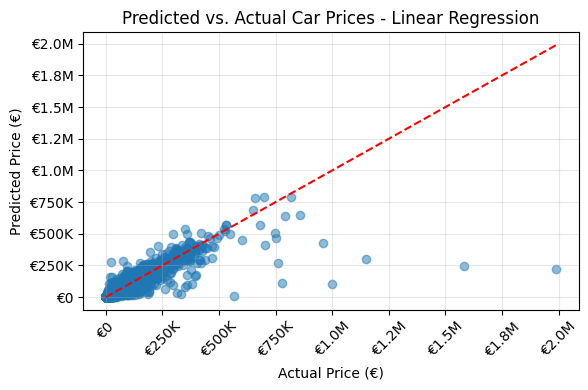

In [12]:
scatter_prediction(y_test, y_pred_lr, "Linear Regression")

In [14]:
# Lade df_mit_segment.csv und führe Join mit results auf 'brand' und 'model' durch
df_segment = pd.read_csv('../../../df_mit_segment.csv')

# Merge results mit df_segment auf 'brand' und 'model'
results = results.merge(df_segment[['brand', 'model', 'segment']], on=['brand', 'model'], how='left')

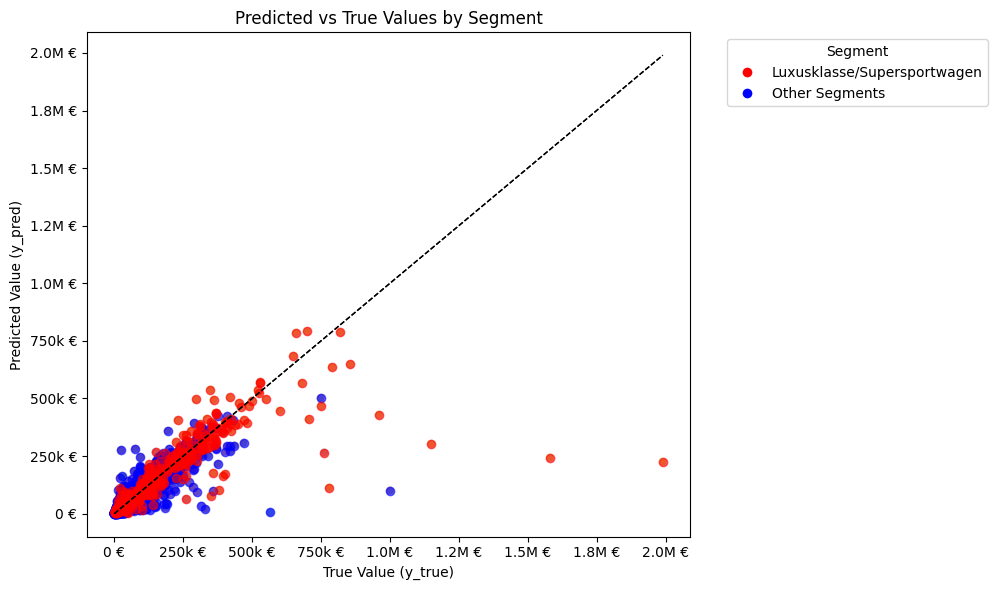

In [15]:
from matplotlib.lines import Line2D

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='y_true', y='y_pred', hue='segment', alpha=0.6, palette='tab10')
plt.plot([results.y_true.min(), results.y_true.max()],
         [results.y_true.min(), results.y_true.max()],
         color='black', linestyle='--', linewidth=1)
plt.xlabel("True Value (y_true)")
plt.ylabel("Predicted Value (y_pred)")
plt.title("Predicted vs True Values by Segment")
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
custom_palette = {'Luxusklasse': 'red', 'Supersportwagen': 'red'}
default_color = 'blue'

# Assign colors: red for the two segments, blue for the rest
results['color'] = results['segment'].map(lambda x: custom_palette.get(x, default_color))

# Plot
for seg in results['segment'].unique():
    subset = results[results['segment'] == seg]
    plt.scatter(subset['y_true'], subset['y_pred'],
                color=custom_palette.get(seg, default_color),
                alpha=0.6, label=seg if seg in custom_palette else None)

# Plot the reference line
plt.plot([results.y_true.min(), results.y_true.max()],
         [results.y_true.min(), results.y_true.max()],
         color='black', linestyle='--', linewidth=1)

# Custom legend: only show the two highlighted segments and "Other"
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Luxusklasse/Supersportwagen', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Other Segments', markerfacecolor='blue', markersize=8)
]
plt.legend(handles=legend_elements, title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
# Format both axes with thousands separator and Euro sign
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,} €"))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{int(y):,} €"))
import matplotlib.ticker as mticker

def thousands_formatter(x, pos):
    if abs(x) >= 1_000_000:
        return f"{x/1_000_000:.1f}M €"
    elif abs(x) >= 1_000:
        return f"{x/1_000:.0f}k €"
    else:
        return f"{int(x)} €"

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.show()